## Setup

In [51]:
from functions import Model, get99, splitData, dropMissingValues, z_score, outliers_knn, outliers_dbscan, getNoise, getRelFeatures, drop_features, getCombinations, get_unique_list, bold, blue, red, green, getBestModel, np_to_df, df_to_np, drop99_all, z_score_individual, train_test_to_df, loadModel
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

warnings.filterwarnings('ignore')

## Testdata

Get Test Data from CSV

In [52]:
#Get test Data
NAME_TEST_FILE = "house_data_test"
df_test_data = pd.read_csv("data/csv/"+NAME_TEST_FILE+".csv", sep=';') 

# remove unnamed column
df_test_data = df_test_data.iloc[:, 1:]

#Transform string to datetime
try: 
    df_test_data["date"] = pd.to_datetime(df_test_data["date"])
except Exception as e:
    print("Error: Trying to convert to date")

Drop Missing Values

In [53]:
print(f'There are {blue(df_test_data.isnull().sum().sum())} Missing Values')
df_test_data = dropMissingValues(df_test_data) 

There are 8 Missing Values


Drop Values with 999..99 

In [54]:
try:
    outlier_list_99 = get99(df_test_data) 
    df_test_data = drop99_all(df_test_data, outlier_list_99)
    print(green('99s dropped'), "\n")
except Exception as e:
    pass

99s dropped 



In [55]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4877 entries, 0 to 4998
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             4877 non-null   int64         
 1   date           4877 non-null   datetime64[ns]
 2   price          4877 non-null   float64       
 3   bedrooms       4877 non-null   int64         
 4   bathrooms      4877 non-null   float64       
 5   sqft_living    4877 non-null   int64         
 6   sqft_lot       4877 non-null   int64         
 7   floors         4877 non-null   float64       
 8   waterfront     4877 non-null   float64       
 9   dis_super      4877 non-null   float64       
 10  view           4877 non-null   float64       
 11  condition      4877 non-null   float64       
 12  grade          4877 non-null   float64       
 13  sqft_above     4877 non-null   float64       
 14  sqft_basement  4877 non-null   float64       
 15  yr_built       4877 n

##

## Model

Get saved Model from Grid-Search

In [56]:
model_obj = loadModel()

Model: GradientBoostingRegressor(random_state=1) Combination: ('outlier_list_z_score_ind_',) Features: 23


Making sure Shapes are similar

In [57]:
print(f'Training Data Features: {blue(len(model_obj.get_features()))}')
print(f'Testing Data Features: {blue(len(df_test_data.columns.to_list()))}')

features_to_drop = list(set(df_test_data.columns.to_list()) - set(model_obj.get_features()))
print(f'Features to drop from Testdata: {red(features_to_drop)}')

Training Data Features: 23
Testing Data Features: 25
Features to drop from Testdata: ['date', 'price']


Integrate test Data into Model

In [58]:
X_train, X_test, y_train, y_test = model_obj.get_data()

#Drop Features
X_test, y_test = df_test_data.drop(columns=features_to_drop), df_test_data["price"]

#Tranform Test-Data
if isinstance(model_obj.get_model(), Lasso) == True:
    scaler = StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)

model_obj.set_data(X_train, X_test, y_train, y_test)

#Train Model
model_obj.train()

#Predict
mae, score = model_obj.summary()
predictions = model_obj.pred()

In [59]:
#Evaluate
df_test_data["price_pred"]  = predictions
df_test_data["diff"] = df_test_data["price"]  - df_test_data["price_pred"]  
df_test_data.loc[:, ["price", "price_pred", "diff"]].T.applymap('{:,.2f}'.format)

,0,1,2,3,4,5,6,7,8,9,...,4988,4989,4990,4991,4992,4993,4995,4996,4997,4998
price,"725,000.00","495,000.00","565,000.00","535,000.00","571,000.00","387,500.00","512,000.00","765,000.00","240,000.00","887,000.00",...,"454,000.00","279,000.00","750,000.00","820,000.00","249,950.00","1,500,000.00","2,125,000.00","554,000.00","450,000.00","278,000.00"
price_pred,"649,600.74","502,520.89","590,182.17","512,192.45","467,518.24","413,188.48","502,075.25","798,443.09","288,572.40","725,491.80",...,"384,787.41","270,073.47","494,101.22","1,173,730.02","257,401.66","1,227,827.40","1,303,690.91","384,795.50","412,640.33","250,467.95"
diff,"75,399.26","-7,520.89","-25,182.17","22,807.55","103,481.76","-25,688.48","9,924.75","-33,443.09","-48,572.40","161,508.20",...,"69,212.59","8,926.53","255,898.78","-353,730.02","-7,451.66","272,172.60","821,309.09","169,204.50","37,359.67","27,532.05"


In [60]:
#df_test_data.loc[:, ["price", "price_pred", "diff"]].describe().T.applymap('{:,.2f}'.format)

## Visulize Predictions

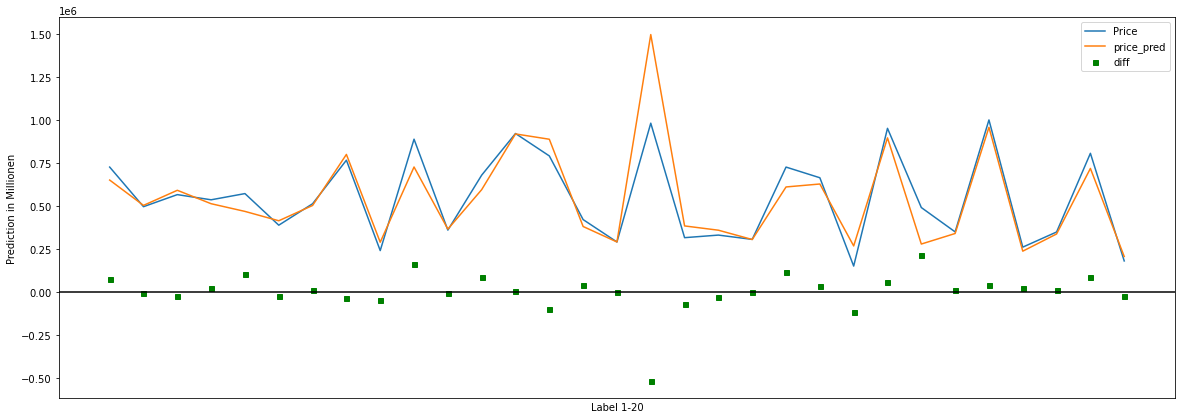

In [61]:
plt.figure(figsize=(20,7))
#Prediction der Modelle für die ersten 20 Zeilen
x = 30
real = df_test_data.loc[:x, "price"]
pred = df_test_data.loc[:x,"price_pred"]
diff = df_test_data.loc[:x,"diff"]

plt.plot(real, label="Price")
plt.plot(pred, label="price_pred")
plt.plot(diff, "gs", ms=5, label="diff")
plt.axhline(y=0, color='black', linestyle='-')

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Prediction in Millionen")
plt.xlabel("Label 1-20")
plt.legend(loc="best")

plt.show()

In [62]:
print(bold("MAE: "), blue(mae))

MAE:  80667.31
